In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns

In [2]:
load_epoch, load_variational, load_k, load_lin = 1000, False, 1, 'nonlinear' #define model that shall be loaded for shapley
RESULTPATH = '/home/pgk/PycharmProjects/Proteomics/TCPA-Imputation/results/shapley/data/'

filt = [load_epoch, load_variational, load_k, load_lin]
os.getcwd()

'/home/pgk/PycharmProjects/Proteomics/TCPA-Imputation'

In [3]:
filenames = os.listdir(RESULTPATH)

def load_file(filename):
    file_data = pd.read_csv(RESULTPATH + filename)
    target = filename.split('_')[3]
    file_data['target'] = target
    return file_data
data = pd.concat([load_file(filename) for filename in filenames])
data['target'] = data['target'].astype(int)

FileNotFoundError: [Errno 2] No such file or directory: '/home/pgk/PycharmProjects/Proteomics/TCPA-Imputation/results/shapley/data/'

In [4]:
data_wide = pd.pivot_table(data, values = 'shapley', index='masked_protein',

                    columns='target')
#data_wide.values[[np.arange(data_wide.shape[0])]*2] = 0
data_wide.values[[np.arange(13)]*2] = 0


NameError: name 'data' is not defined

In [5]:
#sns.heatmap((data_wide>=0.001)*1.0)
sns.heatmap(data_wide)

NameError: name 'data_wide' is not defined

In [6]:
#todo: ROC

In [7]:
# for asymmetric data
func_mat = pd.read_csv('/home/pgk/PycharmProjects/Proteomics/TCPA-Imputation/results/shapley/adjacency/function.csv', header=None)
func_mat.values[[np.arange(func_mat.shape[0])]*2] = 0
func_mat.shape
sns.heatmap(np.abs(func_mat))

FileNotFoundError: [Errno 2] File b'/home/pgk/PycharmProjects/Proteomics/TCPA-Imputation/results/shapley/adjacency/function.csv' does not exist: b'/home/pgk/PycharmProjects/Proteomics/TCPA-Imputation/results/shapley/adjacency/function.csv'

In [8]:
func_mat_ = func_mat.copy()
func_mat_['p'] = func_mat_.index
func_long = pd.melt(func_mat_, id_vars=['p'], var_name='q')

NameError: name 'func_mat' is not defined

In [9]:
data.rename(columns = {'masked_protein': 'p', 'target': 'q'}, inplace=True)
new_data = pd.merge(data, func_long, how = 'left', left_on =['p', 'q'], right_on = ['p', 'q'])
new_data_filtered = new_data[new_data['p']!=new_data['q']]
new_data_filtered.loc[:,'value'] = np.abs(new_data_filtered['value'])
new_data_filtered.loc[:,'interaction'] = (new_data_filtered['value']!=0)*1.0
#new_data_filtered= new_data_filtered[(new_data_filtered['value']==0) | (new_data_filtered['value']>0.005)]

NameError: name 'data' is not defined

In [10]:
for_plot = new_data_filtered[new_data_filtered['interaction']==1]
plt.scatter(for_plot['value'], for_plot['shapley'])
m, b = np.polyfit(for_plot['value'], for_plot['shapley'], 1)
plt.plot(for_plot['value'], m*for_plot['value'] + b)

NameError: name 'new_data_filtered' is not defined

In [11]:
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer
import matplotlib.pyplot as plt

y_test = new_data_filtered['interaction']
y_pred_proba = new_data_filtered['shapley']


fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

NameError: name 'new_data_filtered' is not defined

In [12]:
function_mat = pd.read_csv('/home/pgk/PycharmProjects/Proteomics/TCPA-Imputation/results/shapley/adjacency/function.csv', header=None)
function_mat.values[[np.arange(func_mat.shape[0])]*2] = 0

FileNotFoundError: [Errno 2] File b'/home/pgk/PycharmProjects/Proteomics/TCPA-Imputation/results/shapley/adjacency/function.csv' does not exist: b'/home/pgk/PycharmProjects/Proteomics/TCPA-Imputation/results/shapley/adjacency/function.csv'

NameError: name 'func_mat' is not defined

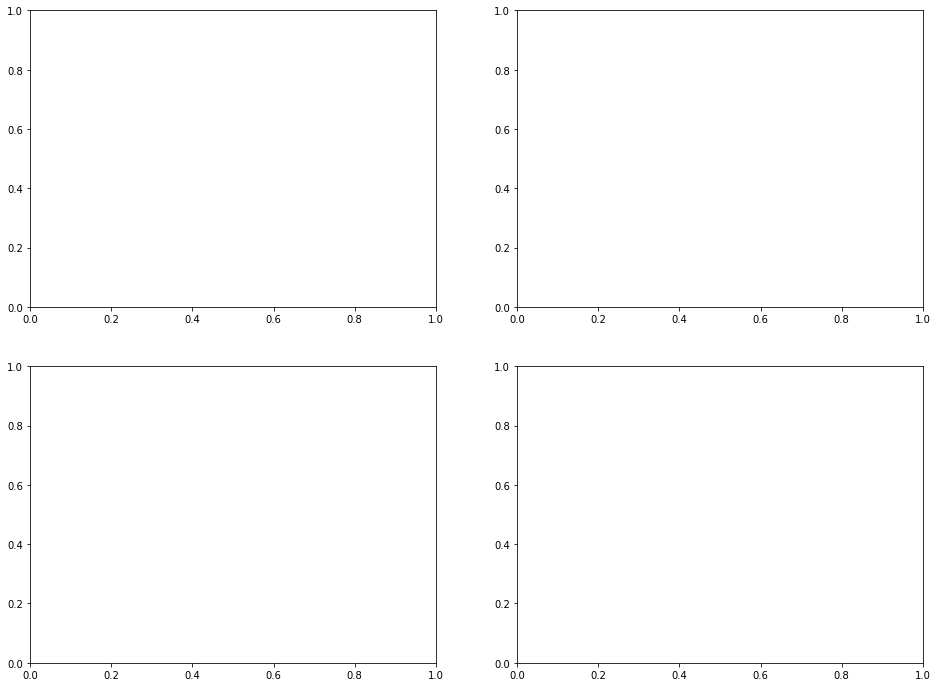

In [13]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(16, 12))
sns.heatmap(np.abs(func_mat), ax = ax1)
ax1.set_title('ground truth')
sns.heatmap(data_wide, ax=ax2)
ax2.set_title("Shapley reconstruction")
ax3.plot(fpr,tpr,label="data 1, auc="+str(auc))
ax3.set_title("ROC")
ax4.scatter(for_plot['value'], for_plot['shapley'])
ax4.plot(for_plot['value'], m*for_plot['value'] + b)
ax4.set_title("Regression")
plt.savefig('results/figures/shapley_reconstruction.png')

In [ ]:
sns.heatmap(np.abs(func_mat))

In [14]:
dataframe = np.loadtxt('results/data/data.csv', delimiter=',').transpose()
dataframe.shape
correlation = np.corrcoef(dataframe)
np.fill_diagonal(correlation, 0)

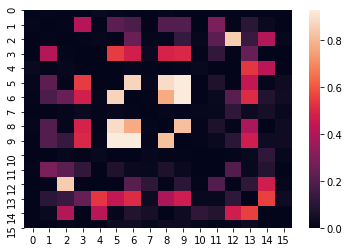

In [251]:
sns.heatmap(np.abs(correlation))